In [1]:
%load_ext autoreload
%autoreload 2

(<Figure size 1200x1200 with 16 Axes>,
 array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
         <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
        [<Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
         <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>],
        [<Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
         <Axes: title={'center': '10'}>, <Axes: title={'center': '11'}>],
        [<Axes: title={'center': '12'}>, <Axes: title={'center': '13'}>,
         <Axes: title={'center': '14'}>, <Axes: title={'center': '15'}>]],
       dtype=object))

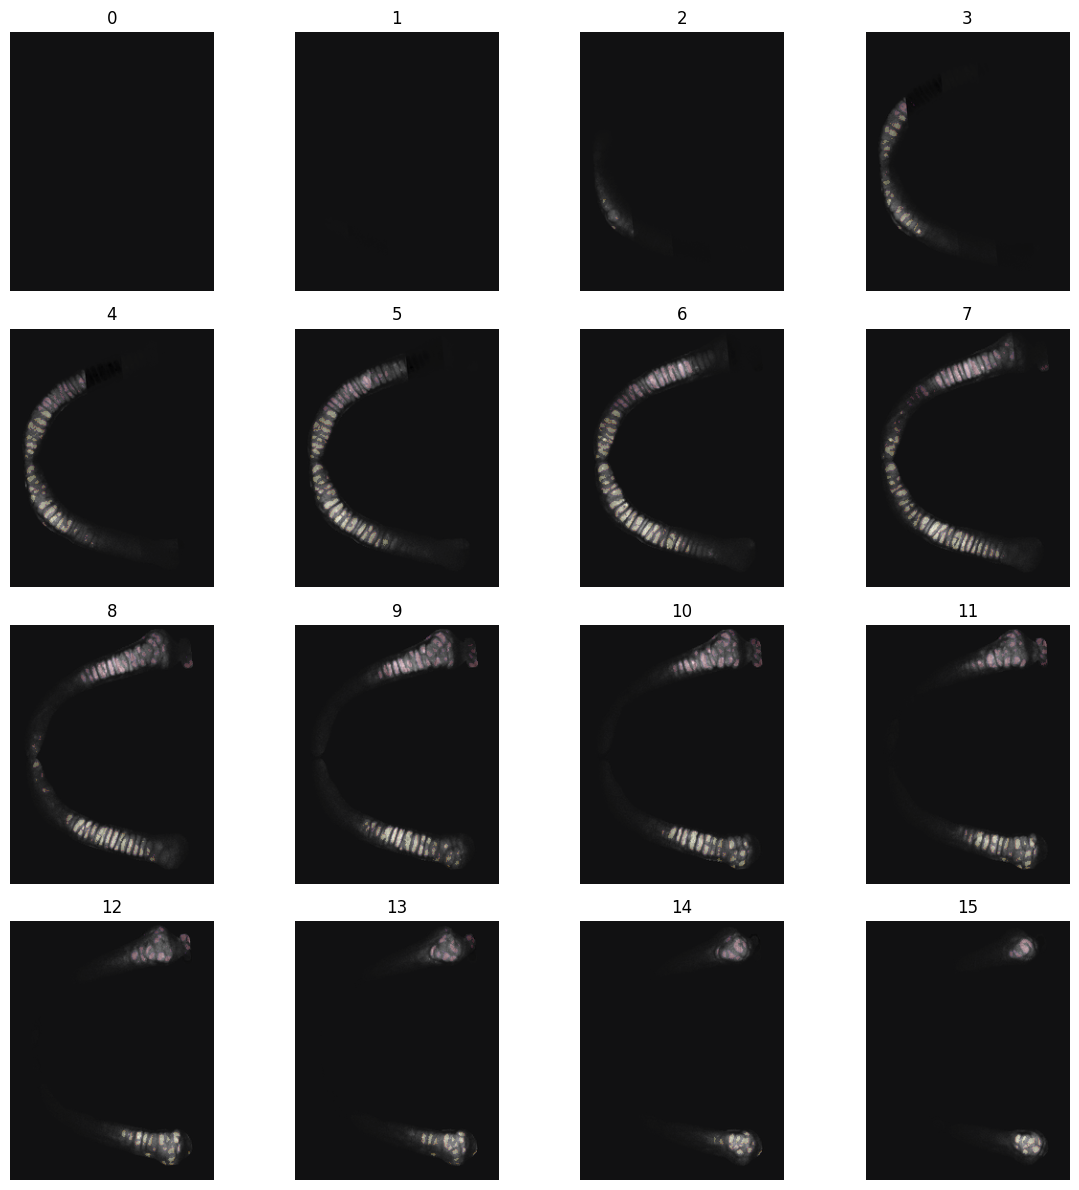

In [2]:
"""
Display two images I'm using for training

"""

import os
import numpy as np
from dev import plot, util

folder = os.path.join(util.userconf()["rdsf_dir"], "Yushi/Videos/theta_1/Code/segmenter/notebooks/projects/20180701_cell_segment/")
img_path = folder + "jaw_raw_image.npy"
mask_path = folder + "jaw_labels.npy"

img = np.load(img_path)
mask = np.load(mask_path)

# Convert the mask to labels
mask[(mask < 32) & (mask > 0)] = 1
mask[mask >= 32] = 2

img = np.transpose(img, (2, 0, 1))
mask = np.transpose(mask, (2, 0, 1))

plot.plot_arr(img, mask)

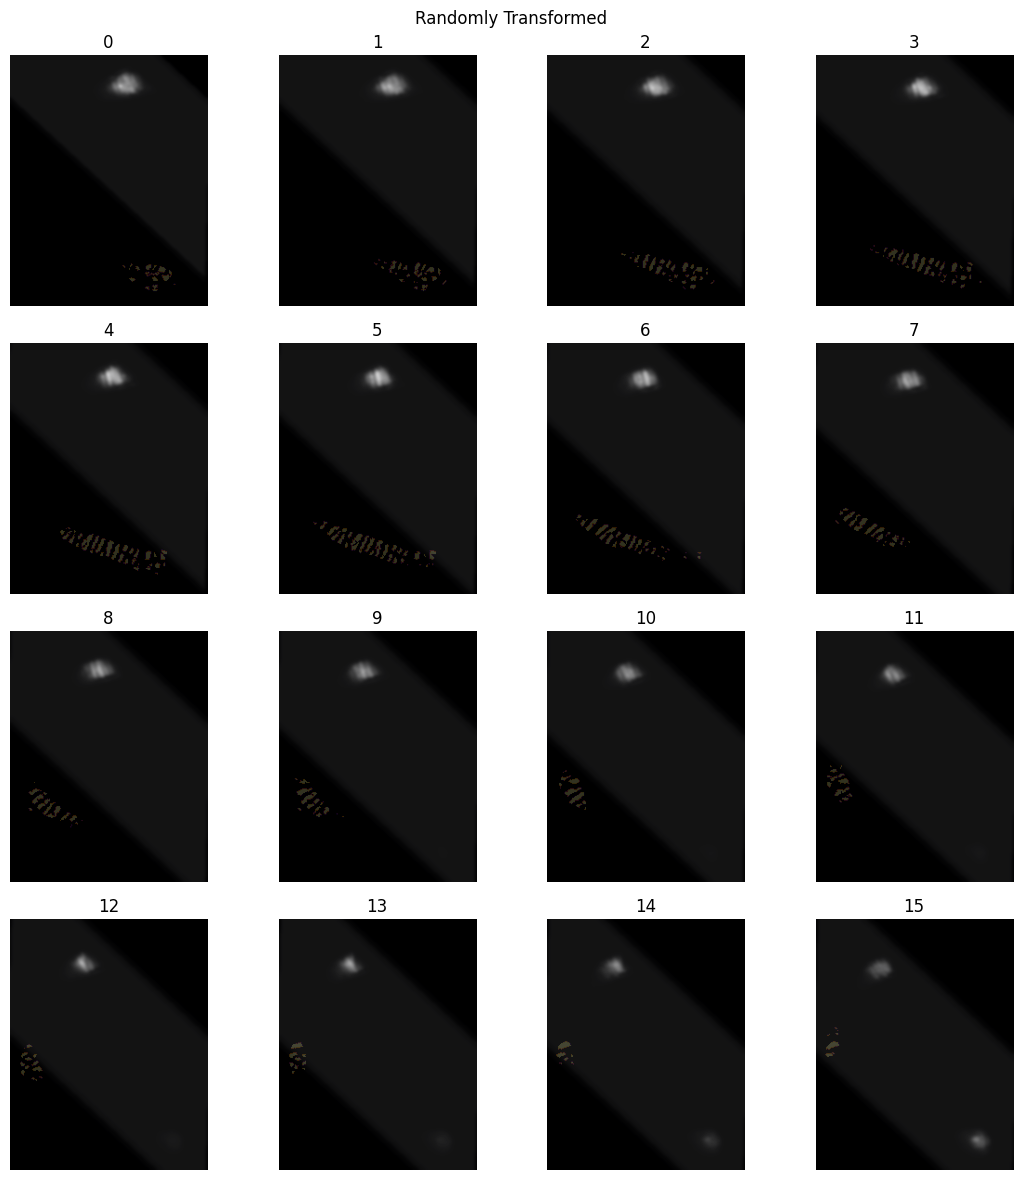

In [3]:
""" Convert images to tensors and apply transformations """

from dev import image_io

transform = image_io.random_transforms()
subjects = [image_io.subject(img, mask) for _ in range(3)]

subjectdataset = image_io.subject_dataset(subjects, transform)

fig, _ = plot.plot_arr(
    image_io.pytorch2img(subjectdataset[0].image.data.squeeze()),
    image_io.pytorch2img(subjectdataset[0].label.data.squeeze()),
)
fig.suptitle("Randomly Transformed")
fig.tight_layout()

In [4]:
""" Create a DataLoader"""

import torch
import torch.utils
import torchio as tio
from dev.util import userconf

uconf = userconf()
patch_size = [int(x) for x in uconf["patch_size"].split(",")]

# Choose the probability of patches being centred on each value
label_probs = {0: 1, 1: 1, 2: 1}
patch_sampler = tio.LabelSampler(patch_size, "label", label_probs)
patches = tio.Queue(
    subjectdataset,
    max_length=10000,
    samples_per_volume=6,
    sampler=patch_sampler,
    num_workers=10,
)


train_loader = torch.utils.data.DataLoader(
    patches,
    batch_size=uconf["batch_size"],
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
)

In [5]:
"""
Load a model

"""

from dev.segmentation import model as lib_model

model = lib_model.model()
# lib_model.draw_model(model, "model.pdf")

In [6]:
"""
Create an optimiser + choose a loss function

"""

from monai.losses import TverskyLoss

optimiser = lib_model.optimiser(model)
loss = TverskyLoss(include_background=True, alpha=0.2)

optimiser

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0026
    maximize: False
    weight_decay: 0
)

In [7]:
import warnings
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    # Yellow text
    yellow = "\033[33m"
    clear = "\033[0m"
    warnings.warn(f"{yellow}This might not be what you want!{clear}")
print(f"Using {device} device")

_ = model.to(device)

Using cuda device


In [9]:
model, loss, val_loss = lib_model.train(
    model,
    optimiser,
    loss,
    train_loader,
    train_loader,
    device=device,
    epochs=3,
)

  0%|          | 0/3 [00:00<?, ?it/s]


torch.Size([8, 256, 2, 2, 2]) torch.Size([8, 256, 2, 2, 2])
torch.Size([8, 128, 4, 4, 4]) torch.Size([8, 128, 4, 4, 4])
torch.Size([8, 64, 8, 8, 8]) torch.Size([8, 64, 7, 7, 7])


RuntimeError: The size of tensor a (8) must match the size of tensor b (7) at non-singleton dimension 4